<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/04_Recurrent_Neural_Networks.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Neural Networks - Recurrent Neural Networks

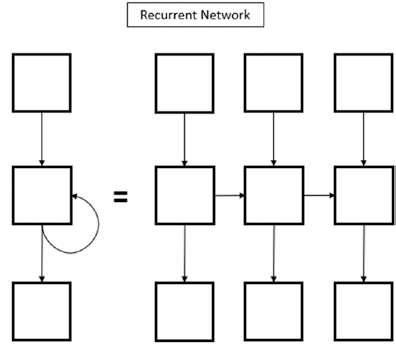

The difference in the RNN block is that there is a feedback loop. Where each input of a fully connected network is completely
independent, the inputs of an RNN have a feedback relation with each other. This makes the model good to fit data that has sequences, like Times series or written text.
Due to this architecture difference, there is not just one input in each unit, but there are two.

Also, the tanh activation layer is the most common for RNN instead of the ReLU. The reason for this is that for long sequences, the ReLU layer suffers from the exploding gradient problem: the repeated multiplication with weights is acting like an exponentiation that
makes it explode. The tanh activation layer does not have this problem, as the values are forced to stay between -1 and 1.

#### 1 - Importing Data

Data: Jena Climate dataset

Period of Record: From 2009 to 2016

Number of observations: 420551
Number of variables: 14
Variable name definitions:

1.   Date Time - sample date in DD.MM.YYYY hh:mm:ss format
1.   p (mbar): Atmospheric pressure measured in millibars (mbar).
1.   T (degC): Air temperature measured in degrees Celsius (°C).
1.   Tpot (K): Potential temperature measured in Kelvin (K).
1.   Tdew (degC): Dew point temperature measured in degrees Celsius (°C).
1.   rh (%): Relative humidity measured as a percentage (%).
1.   VPmax (mbar): Saturation vapor pressure measured in millibars (mbar).
1.   VPact (mbar): Actual vapor pressure measured in millibars (mbar).
1.   VPdef (mbar): Vapor pressure deficit measured in millibars (mbar).
1.   sh (g/kg): Specific humidity measured in grams per kilogram (g/kg).
1.   H2OC (mmol/mol): Water vapor concentration measured in millimoles per mole (mmol/mol).
1.   rho (g/m^3): Air density measured in grams per cubic meter (g/m^3).
1.   wv (m/s): Wind velocity measured in meters per second (m/s).
1.   max. wv (m/s): Maximum wind velocity measured in meters per second (m/s).
1.   wd (deg): Wind direction measured in degrees.


Source: https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip.

13568290/13568290 [==============================] - 0s 0us/step
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3          3.33          3.11          0.22       1.94             3.12       1307.75      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4          3.23          3.02          0.21       1.89             3.03       1309.80      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9          3.21          3.01          0.20       1.88             3.02       1310.24      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2          3.26          3.07          0.19       1.92             3.08       1309.19      

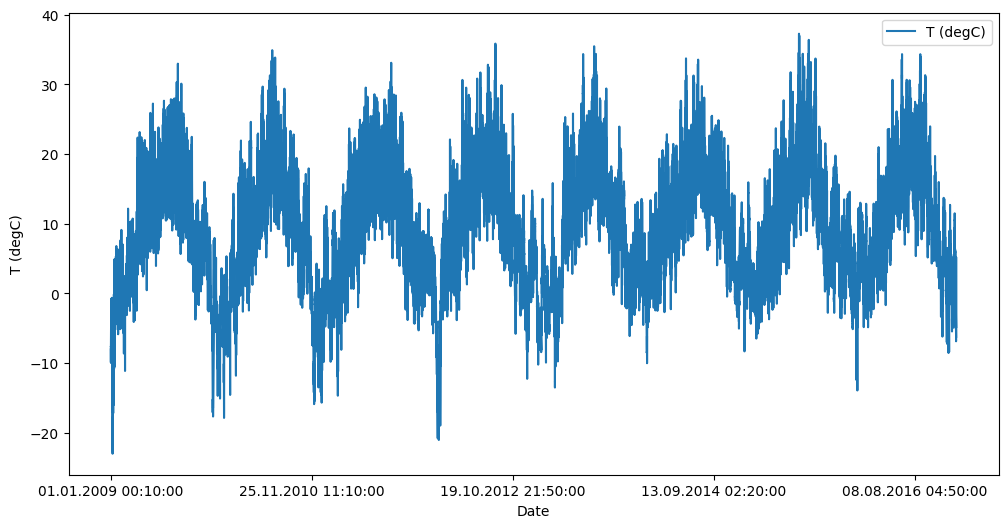

In [1]:
import keras
import pandas as pd
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
del zip_file

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(df.head())

dates = df['Date Time']

# Display all data
ax = df.plot(x='Date Time', y='T (degC)',figsize=(12,6))
ax.set_ylabel('T (degC)')
ax.set_xlabel('Date')

plt.show()

df = df.drop('Date Time', axis=1)

cols = ['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
'H2OC', 'rho', 'wv', 'mwv', 'wd']
df.columns = cols



#### 2 - Data Preparation - Scaling and creation of the Sequence Data

In this example, we’ll do a forecast of the temperature 12 hours later.
Now what we did in the fully connected model was to create lagged variables. There was one y variable (which was not lagged), and the independent variables were lagged values of the y variable and a lot of other variables. The first lag was at 72 time steps, so that the model would use the data from 12 hours ago to predict the now.

In the RNN, this is not what we should do, as the RNN learns sequences. A big jump of 72 time steps is not really respecting the sequential variation. Yet we do not just want to predict one time step later, as that would mean that we predict the temperature in 10 minutes from now. What we will do is create a matrix of y variables, with lags as well. Before, we wanted to predict one value 72 time steps into the future, but let’s model to predict each of those 72. This approach is called multistep forecasting.

Other than that, for this model we will use only the temperature data and not the other variables (in order to simplify the sequences construction).

In [2]:
df = df[['T']] ## Keep only temperature data

Next, we proceed with data standardization using the MinMaxScaler

In [3]:
# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

Then, we prepare the sequence data

In [4]:
ylist = list(df['T'])
n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period
X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]
  X_new.append(x_line)
  y_new.append(y_line)
  idx_start = idx_start - 1

# converting list of lists to numpy array
import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)

#### 3 - Split into Train and Test sets and Data Reshape

Now that we have obtained an X and a Y matrix for the model training, as always we need to split it into a train and test set in order to be able to do a fair model evaluation.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

A final step is necessary for fitting the SimpleRNN. The SimpleRNN layer needs
an input format that is 3D, and the shape has to correspond to (n_samples, n_timesteps, n_features). This can be obtained using reshape. This reshape is, unfortunately, necessary sometimes when using Keras, as it is very specific as to the exact shape of the input data.

In [6]:
batch_size = 32
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

#### 4 - Simple RNN Neural Network Construction

The SimpleRNN is a basic RNN cell that is represented by the following architecture:

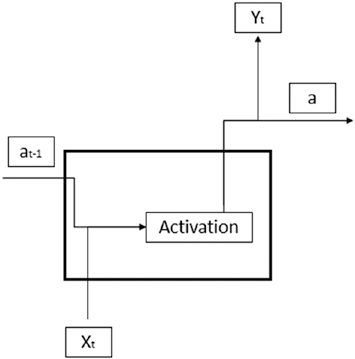

The overall architecture will look as follows:
*   Activation Function: tanh
*   Optimizer: Adam
*   Learning rate: 0.001
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 5


In [7]:
import random
random.seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
simple_model = Sequential([
SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
Dense(y_train.shape[1]),
])
simple_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 72)                648       
                                                                 
Total params: 728 (2.84 KB)
Trainable params: 728 (2.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model

In [8]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)

Fit the model (this step can take long time to complete) and retrieve predictions. In this case, the result is not completeley reproducible due to the randomness

In [9]:
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,
epochs=5,
batch_size=batch_size,
shuffle = True
)
preds = simple_model.predict(X_test_rs)

Epoch 1/5
7040/7040 [==============================] - 119s 17ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0481 - val_mean_absolute_error: 0.0481
Epoch 2/5
7040/7040 [==============================] - 118s 17ms/step - loss: 0.0454 - mean_absolute_error: 0.0454 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 3/5
7040/7040 [==============================] - 116s 16ms/step - loss: 0.0440 - mean_absolute_error: 0.0440 - val_loss: 0.0443 - val_mean_absolute_error: 0.0443
Epoch 4/5
7040/7040 [==============================] - 116s 16ms/step - loss: 0.0430 - mean_absolute_error: 0.0430 - val_loss: 0.0428 - val_mean_absolute_error: 0.0428
Epoch 5/5
4334/4334 [==============================] - 22s 5ms/step


Plot the training history

0.7098344844175091


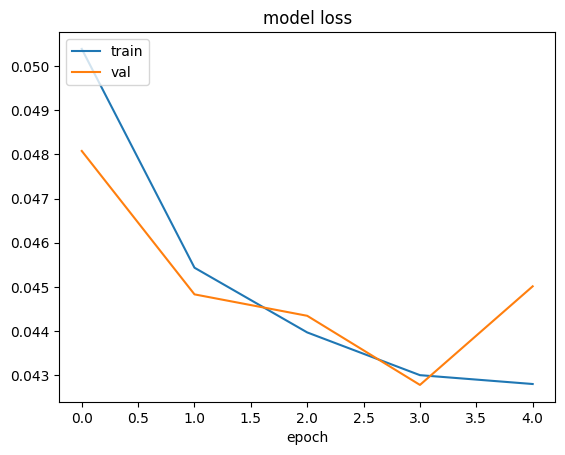

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
print(r2_score(preds, y_test))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Real Values vs Forecasted for a subset of predictions. Firstly we have to invese the transformation that we did with MinMaxScaler on step 2

In [11]:
# To inverse transform the scaled data
t_preds = scaler.inverse_transform(preds)
t_test = scaler.inverse_transform(y_test)

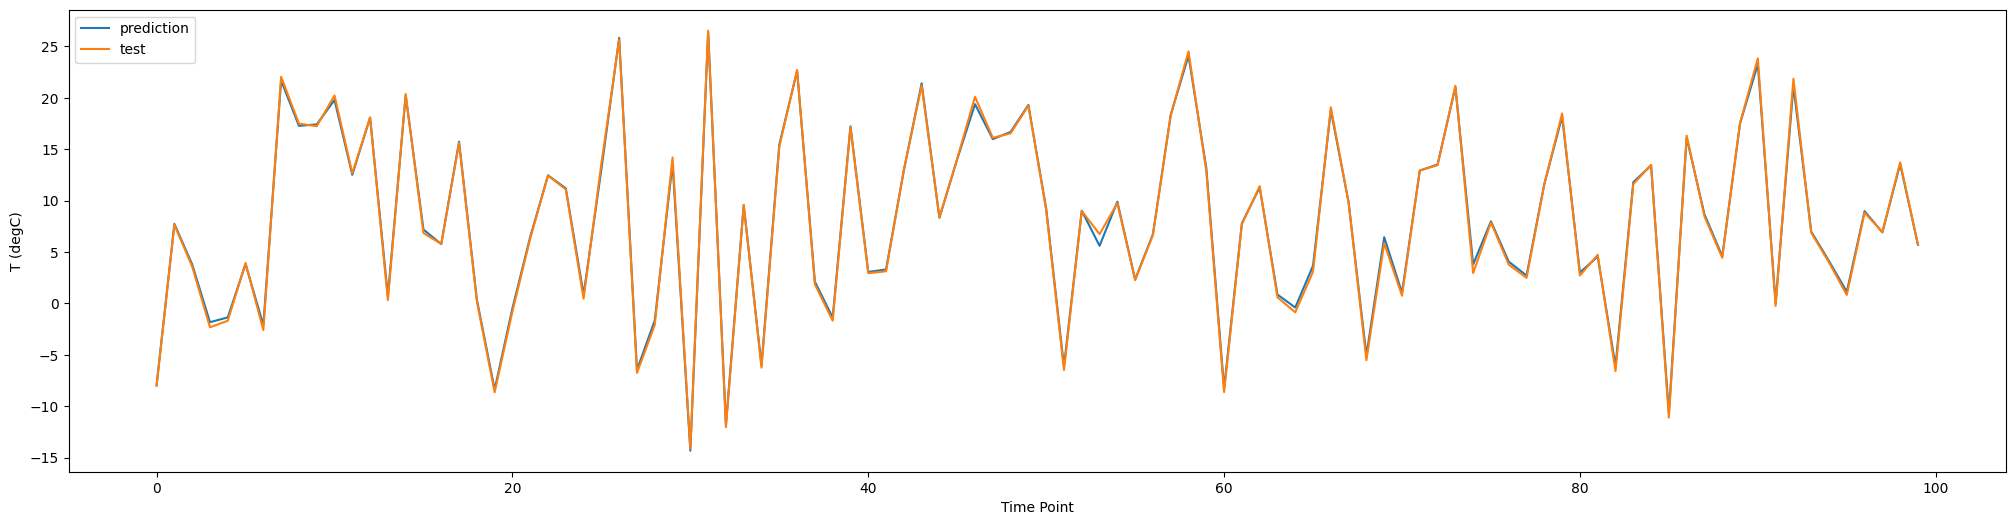

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

# Get the indices of the array
indices = range(len(t_preds[:,0]))

# Plot the array with its index on the x-axis
plt.plot(indices[0:100], t_test[:,0][0:100])
plt.plot(indices[0:100], t_preds[:,0][0:100])

# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('T (degC)')
plt.legend(['prediction', 'test'], loc='upper left')
# Adjust width and height as needed

# Show plot
plt.show()

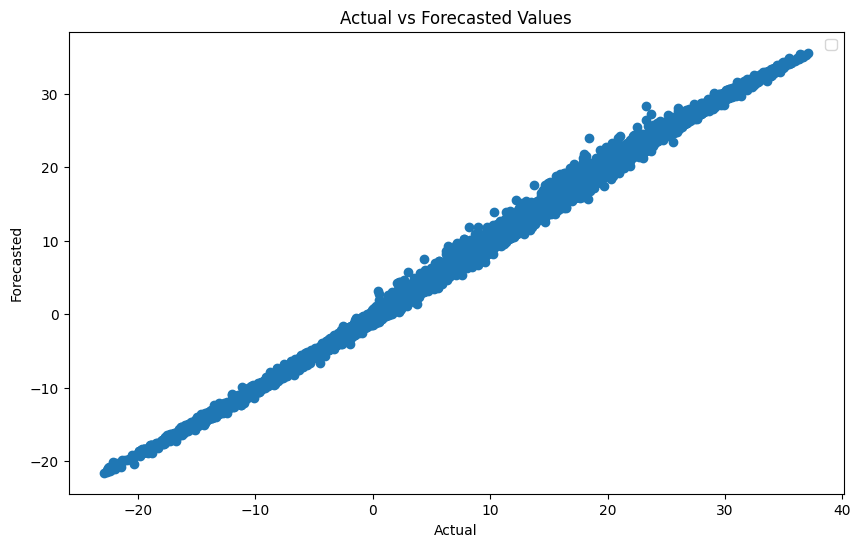

In [13]:
# Plot the variables from both DataFrames
plt.figure(figsize=(10, 6))
plt.scatter(t_test[:,0], t_preds[:,0])

# Add labels and title
plt.xlabel('Actual')
plt.ylabel('Forecasted')
plt.title('Actual vs Forecasted Values')
plt.legend()

# Show plot
plt.show()

#### 5 - Gated Recurrent Unit (GRU) Neural Network Construction


GRU is a more advanced layer, where we have an extra parameter inside the cell which has to be extimated:

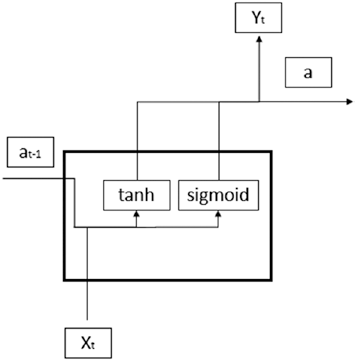

Due to this difference, GRU obtains better general performances than the
SimpleRNN, especially in the identification of long term trends.

The overall architecture will look as follows:
*   Activation Function: tanh
*   Optimizer: Adam
*   Learning rate: 0.01
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 10

In [14]:
random.seed(42)
from tensorflow.keras.layers import GRU
simple_model = Sequential([
GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
Dense(y_train.shape[1]),
])
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 912 (3.56 KB)
Trainable params: 912 (3.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and fit the model

In [15]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,epochs=10,
batch_size=batch_size,
shuffle = True
)

Epoch 1/10
7040/7040 [==============================] - 264s 37ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 2/10
7040/7040 [==============================] - 263s 37ms/step - loss: 0.0283 - mean_absolute_error: 0.0283 - val_loss: 0.0276 - val_mean_absolute_error: 0.0276
Epoch 3/10
7040/7040 [==============================] - 265s 38ms/step - loss: 0.0280 - mean_absolute_error: 0.0280 - val_loss: 0.0296 - val_mean_absolute_error: 0.0296
Epoch 4/10
7040/7040 [==============================] - 273s 39ms/step - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 5/10
7040/7040 [==============================] - 273s 39ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 6/10
7040/7040 [==============================] - 272s 39ms/step - loss: 0.0313 - mean_absolute_error: 0.0313 - val_loss: 0.0343 - val_mean_absolute_

Plot the training history

4334/4334 [==============================] - 34s 8ms/step
0.9084115442344386


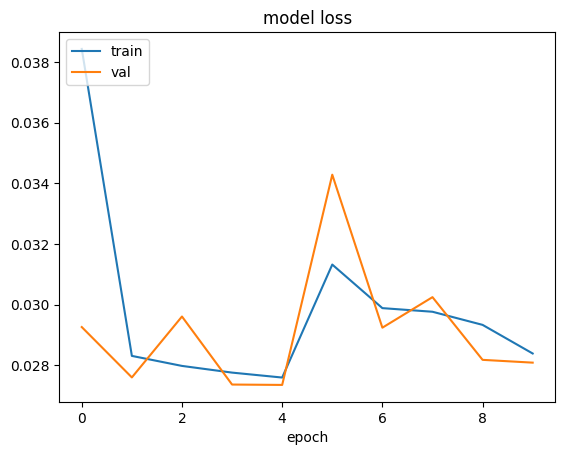

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
preds = simple_model.predict(X_test_rs)
print(r2_score(preds, y_test))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Real values vs forecast for a subset of the predictions. Firstly we have to invese the transformation that we did with MinMaxScaler on step 2

In [17]:
# To inverse transform the scaled data
t_preds = scaler.inverse_transform(preds)
t_test = scaler.inverse_transform(y_test)

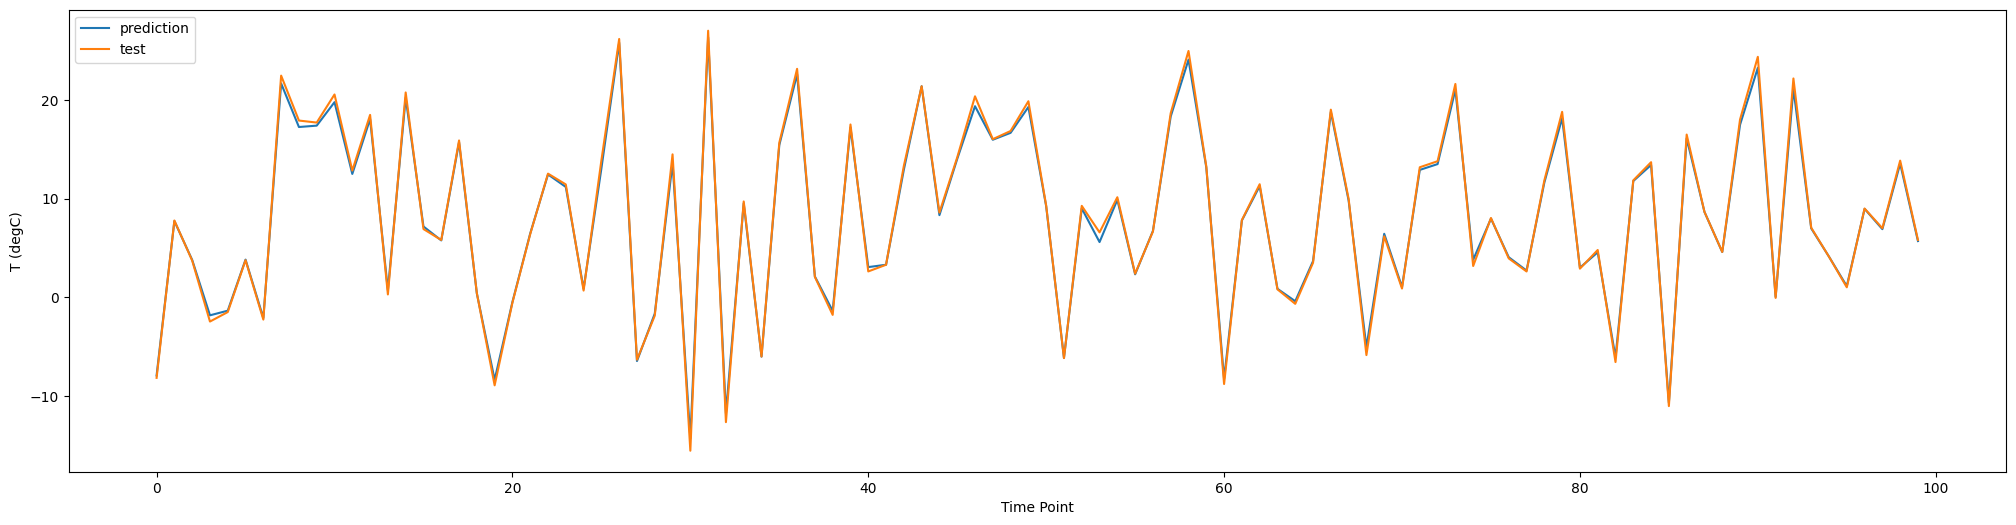

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

# Get the indices of the array
indices = range(len(t_preds[:,0]))

# Plot the array with its index on the x-axis
plt.plot(indices[0:100], t_test[:,0][0:100])
plt.plot(indices[0:100], t_preds[:,0][0:100])

# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('T (degC)')
plt.legend(['prediction', 'test'], loc='upper left')
# Adjust width and height as needed

# Show plot
plt.show()

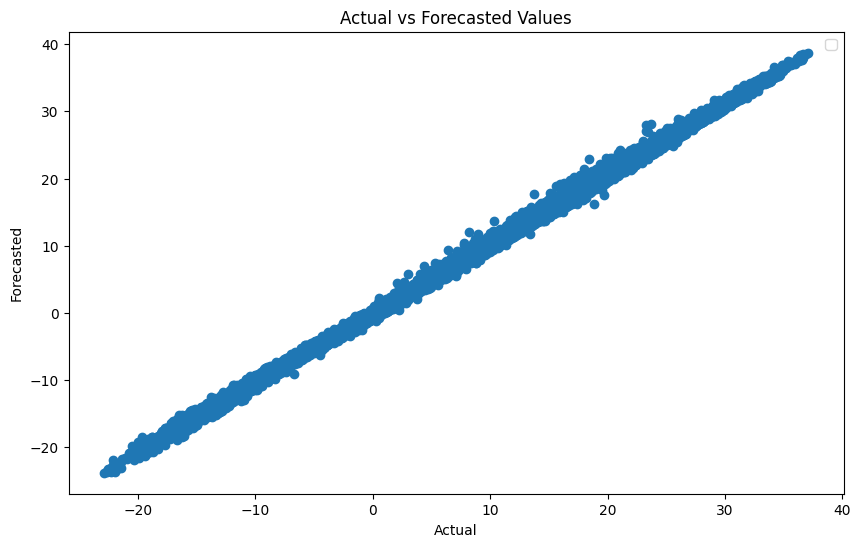

In [19]:
# Plot the variables from both DataFrames
plt.figure(figsize=(10, 6))
plt.scatter(t_test[:,0], t_preds[:,0])

# Add labels and title
plt.xlabel('Actual')
plt.ylabel('Forecasted')
plt.title('Actual vs Forecasted Values')
plt.legend()

# Show plot
plt.show()

#### 6 - Long Short-Term Memory (LSTM) Neural Network Construction

The LSTM cell adds long-term memory in an even more performant way because it
allows even more parameters to be learned. This makes it the most powerful RNN to do forecasting, especially when you have a longer-term trend in data.

LSTM cell has much more components.
Specifically, there are three sigmoids and two tanh operations all combined into the same cell.
There are two weights coming in from the past cell (c and a of the time t-1) and once transformed another two weights are going (c and a of the time t). The X is the input to this cell, and the Y is the output:

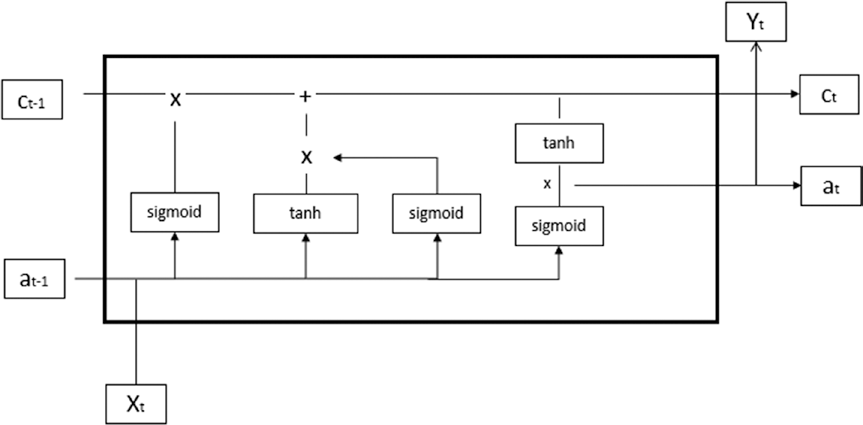

For LSTM is applied the same data preparation.
In the following step, we build a LSTM model with one layer.

The overall architecture will look as follows:
*   Activation Function: tanh
*   Optimizer: Adam
*   Learning rate: 0.01
*   Batch size: 32 (reduce this if you don’t have enough RAM)
*   Epochs: 5

In [20]:
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)
batch_size = 32
simple_model = Sequential([
LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
Dense(y_train.shape[1]),
])
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 72)                648       
                                                                 
Total params: 968 (3.78 KB)
Trainable params: 968 (3.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and fit the model

In [21]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,
epochs=5,
batch_size=batch_size,
shuffle = True
)

Epoch 1/5
7040/7040 [==============================] - 255s 36ms/step - loss: 0.0342 - mean_absolute_error: 0.0342 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 2/5
7040/7040 [==============================] - 245s 35ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 3/5
7040/7040 [==============================] - 245s 35ms/step - loss: 0.0272 - mean_absolute_error: 0.0272 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 4/5
7040/7040 [==============================] - 245s 35ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - val_loss: 0.0268 - val_mean_absolute_error: 0.0268
Epoch 5/5
7040/7040 [==============================] - 247s 35ms/step - loss: 0.0267 - mean_absolute_error: 0.0267 - val_loss: 0.0261 - val_mean_absolute_error: 0.0261


Plot the training history

4334/4334 [==============================] - 33s 7ms/step
0.9255413005850427


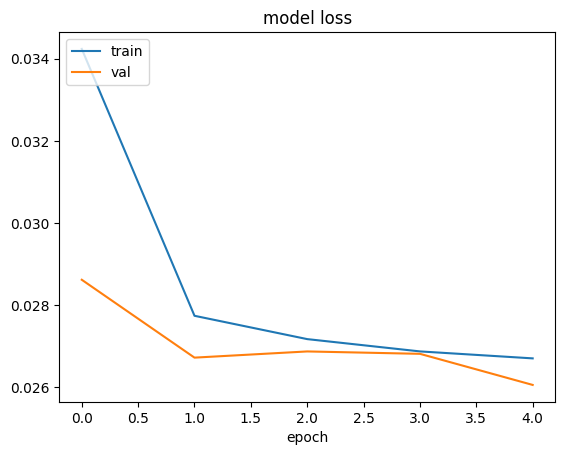

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
preds = simple_model.predict(X_test_rs)
print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Real values vs forecast for a subset of the predictions. Firstly we have to invese the transformation that we did with MinMaxScaler on step 2

In [23]:
# To inverse transform the scaled data
t_preds = scaler.inverse_transform(preds)
t_test = scaler.inverse_transform(y_test)

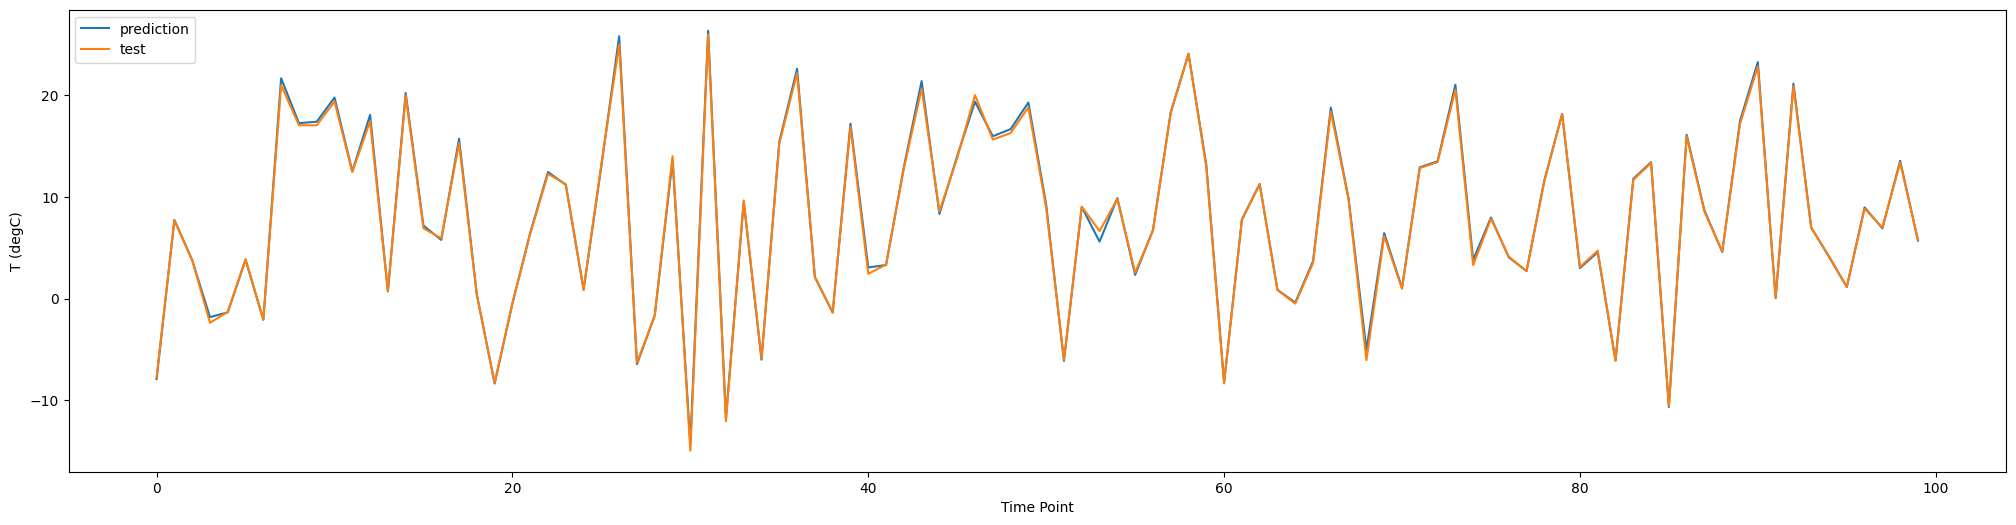

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

# Get the indices of the array
indices = range(len(t_preds[:,0]))

# Plot the array with its index on the x-axis
plt.plot(indices[0:100], t_test[:,0][0:100])
plt.plot(indices[0:100], t_preds[:,0][0:100])

# Add labels and title
plt.xlabel('Time Point')
plt.ylabel('T (degC)')
plt.legend(['prediction', 'test'], loc='upper left')
# Adjust width and height as needed

# Show plot
plt.show()

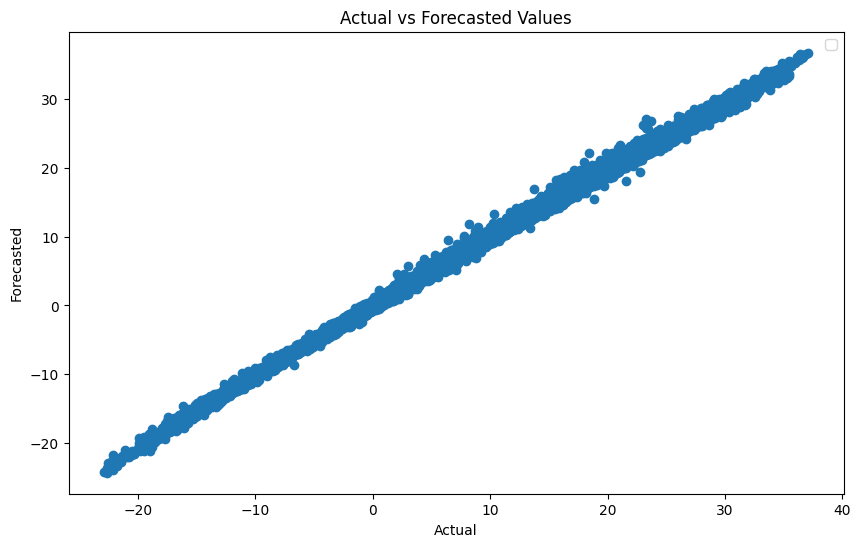

In [25]:
# Plot the variables from both DataFrames
plt.figure(figsize=(10, 6))
plt.scatter(t_test[:,0], t_preds[:,0])

# Add labels and title
plt.xlabel('Actual')
plt.ylabel('Forecasted')
plt.title('Actual vs Forecasted Values')
plt.legend()

# Show plot
plt.show()

#### 7 - Conclusion: Comparison between models
